In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

C:\Miniconda3\envs\ppc\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


In [3]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)

placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.head()

,group,value
0,drug,101
1,drug,100
2,drug,102
3,drug,104
4,drug,102


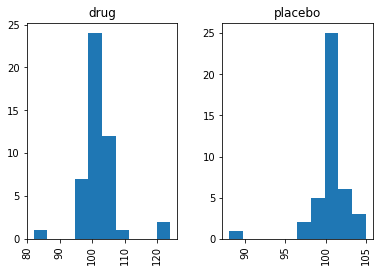

In [4]:
y.hist('value', by='group');

In [5]:
mu_pooled = y.value.mean()

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=mu_pooled, sd=100)
    group2_mean = pm.Normal('group2_mean', mu=mu_pooled, sd=100)
    
    group1_std = pm.HalfNormal('group1_std', sd=100)
    group2_std = pm.HalfNormal('group2_std', sd=100)
    
    nu = pm.Exponential('nu', 1/29.) + 1
    
    group1 = pm.StudentT('drug', nu=nu, mu=group1_mean, sd=group1_std, observed=y1)
    group2 = pm.StudentT('placebo', nu=nu, mu=group2_mean, sd=group2_std, observed=y2)
    
    diff_of_means = pm.Deterministic('diff_of_means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('diff_of_stds', group1_std - group2_std)
    
    trace = pm.sample(draws=1000, chains=2, cores=1)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '6956' (I am process '11116')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, group2_std, group1_std, group2_mean, group1_mean]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:03<00:00, 384.68it/s]


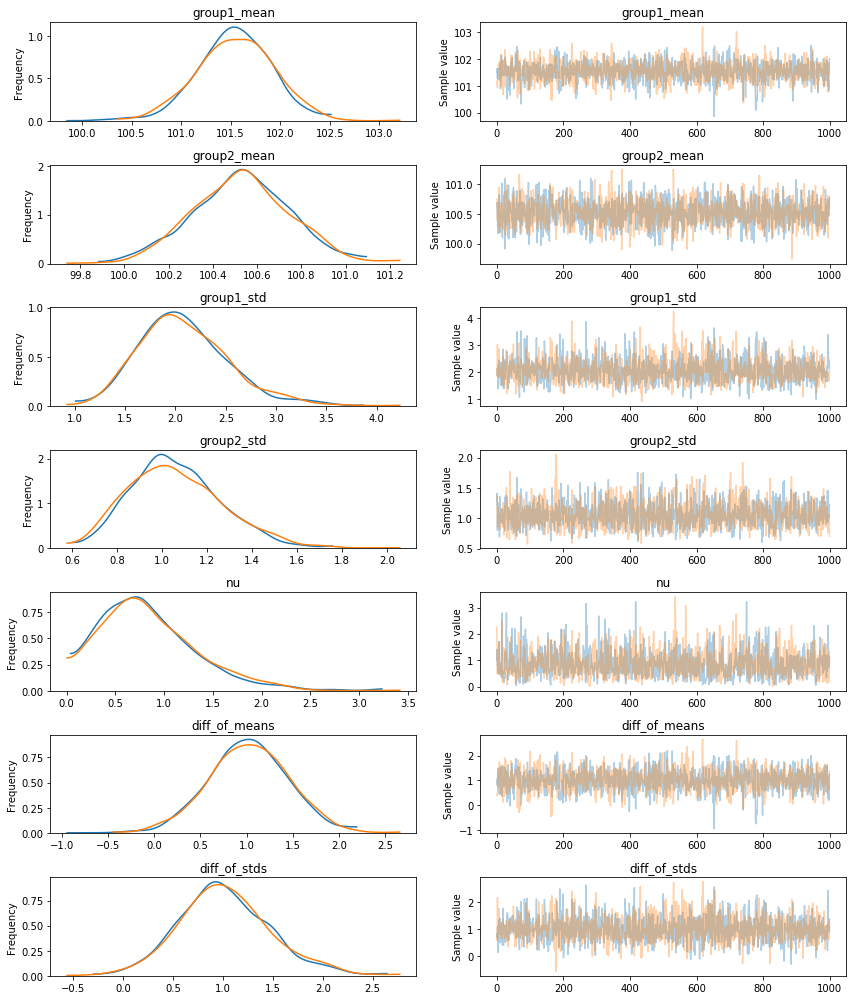

In [6]:
_ = pm.traceplot(trace)

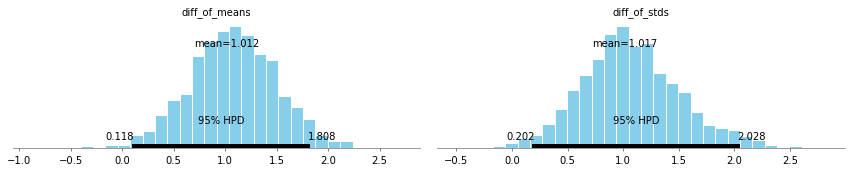

In [16]:
_ = pm.plot_posterior(trace, varnames=['diff_of_means', 'diff_of_stds'])

In [15]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
group1_mean,101.538394,0.380421,0.008514,100.806111,102.276817,1417.338502,1.000459
group2_mean,100.526247,0.217569,0.004552,100.066855,100.912857,1966.612510,0.999556
group1_std,2.078560,0.441772,0.011951,1.236819,2.952526,1329.023411,0.999636
group2_std,1.061203,0.206494,0.004967,0.697598,1.473302,1723.759048,0.999500
nu,0.852496,0.493887,0.012632,0.040655,1.804939,1342.387071,0.999718
diff_of_means,1.012147,0.435718,0.009557,0.117572,1.807971,1430.292215,1.000042
diff_of_stds,1.017357,0.456911,0.010125,0.201701,2.027767,1837.706201,0.999626


In [8]:
df = pm.trace_to_dataframe(trace)

In [9]:
df.head()

,group1_mean,group2_mean,group1_std,group2_std,nu,diff_of_means,diff_of_stds
0,101.512955,100.682456,2.103544,1.281350,1.001542,0.830498,0.822194
1,101.639181,100.585474,2.094259,1.409747,1.403704,1.053707,0.684512
2,101.268929,100.444642,1.856399,0.802377,0.784362,0.824287,1.054022
3,101.638134,100.169736,2.245106,1.124653,0.860926,1.468399,1.120453
4,101.406932,100.676233,1.394314,1.253066,0.510897,0.730699,0.141247
